# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data.

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook.

Also don't forget to **enable GPU** before your training.


In [3]:
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os

from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

[(128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3)]


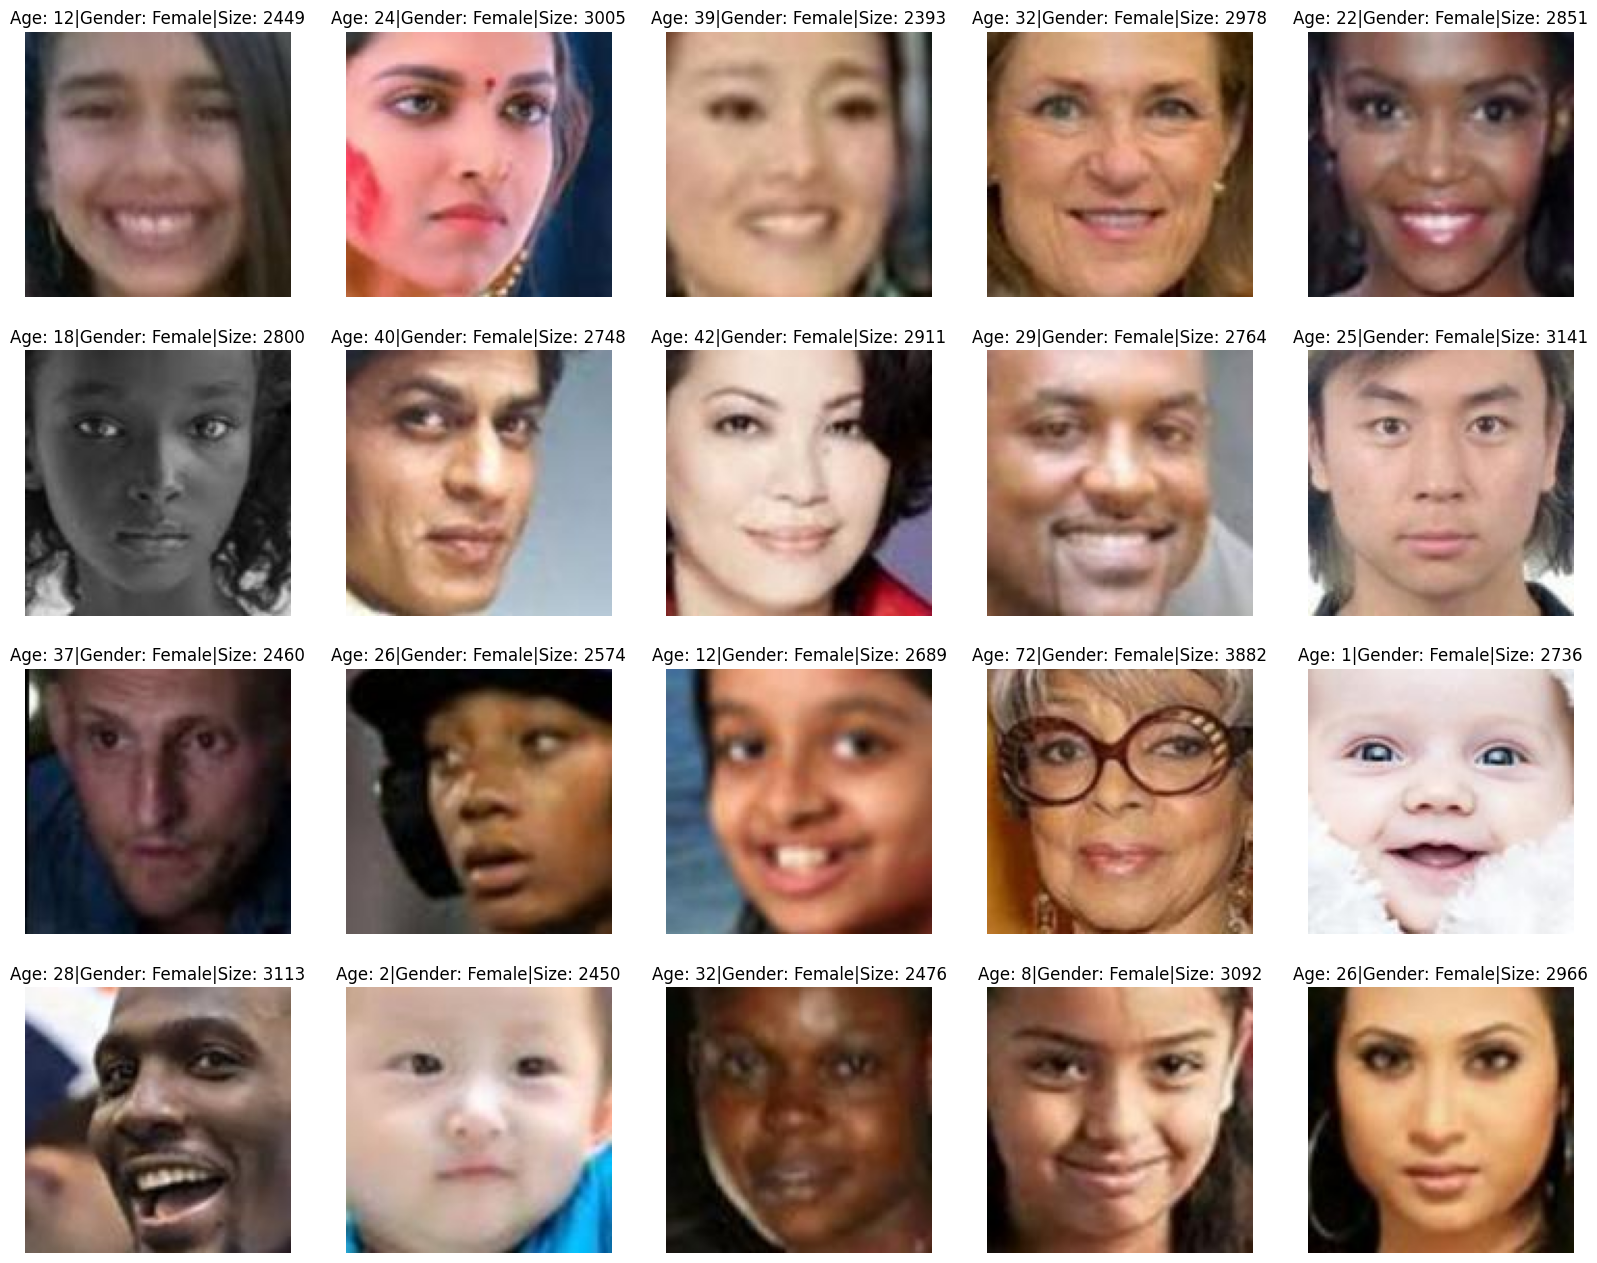

In [4]:
data_dir = pathlib.Path('/content/drive/MyDrive/train_val')

def get_gender(gender_num):
  return 'Male' if 0 else 'Female'

index = 1

result = []

plt.figure(figsize=(20, 20))
for image_file in np.random.choice(list(data_dir.glob('*')), 20):
  plt.subplot(5, 5, index)
  image = plt.imread(image_file)
  result.append(image.shape)
  plt.imshow(image)
  age_str, gender_str = image_file.name.split('_')[:2]
  age, gender = int(age_str), get_gender(int(gender_str))
  plt.title(f'Age: {age}|Gender: {gender}|Size: {image_file.stat().st_size}')
  plt.axis('off')
  index += 1
print(result)

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [5]:
import tensorflow_datasets as tfds

AUTOTUNE = tensorflow.data.AUTOTUNE
img_height = img_width = 128
batch_size = 128

print([i.suffix for i in list(data_dir.glob('*')) if i.suffix == '.jpg'])

image_count = len(list(data_dir.glob('*')))

list_ds = tensorflow.data.Dataset.list_files(str(data_dir/'*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
  print(f.numpy())


val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size // 2)
test_ds = list_ds.take(val_size // 2)

def get_label(file_path):
    # Extract filename from the file path
    filename = tensorflow.strings.split(file_path, os.path.sep)[-1]
    # Split filename by '_' and extract age and gender information
    parts = tensorflow.strings.split(filename, '_')
    age = tensorflow.strings.to_number(parts[0], out_type=tensorflow.int32)
    gender = tensorflow.strings.to_number(parts[1], out_type=tensorflow.int32)
    # Concatenate age and gender into a single label
    return gender, age

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tensorflow.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tensorflow.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tensorflow.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)


['.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg', '.jpg',

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way.
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage.

In [6]:
normalization_layer = layers.Rescaling(1./255)
data_augmentation = tensorflow.keras.Sequential([
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.2),
  layers.RandomFlip(mode='horizontal',
                      input_shape=(img_height,
                                  img_width,
                                  3)),
])
# Official
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)



## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting.

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

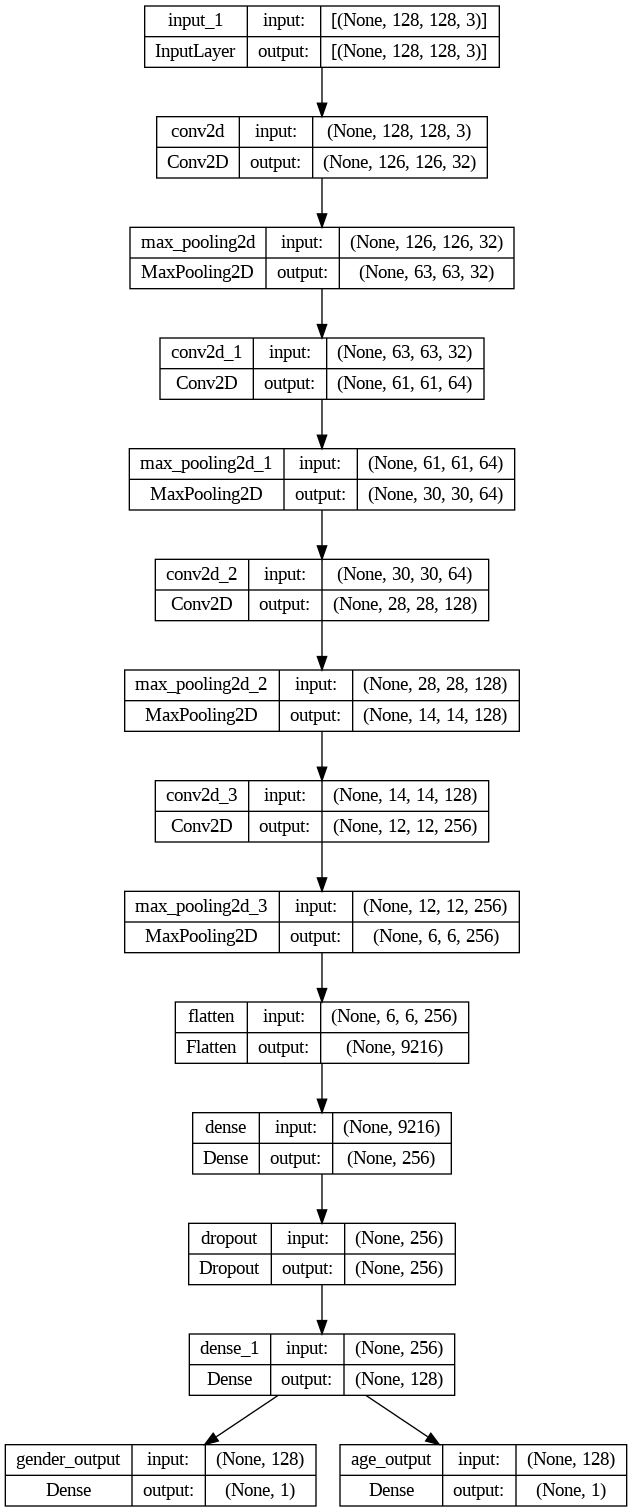

In [7]:
from tensorflow.keras import Model

# Define input shape
input_shape = (128, 128, 3)

# Define CNN model
inputs = layers.Input(shape=input_shape)

# CNN feature extraction layers
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Fully connected layers
x = layers.Dense(256, activation='relu')(x)  # Adjust the number of units to meet the size requirement
x = layers.Dropout(0.5)(x)  # Dropout for preventing overfitting
x = layers.Dense(128, activation='relu')(x)  # Adjust the number of units as needed

# Gender classification output
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

# Age prediction output
age_output = layers.Dense(1, name='age_output')(x)

# Define model with multiple outputs
modelA = Model(inputs=inputs, outputs=[gender_output, age_output])

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by

`modelA = load_model(model_folder+"age_gender_A.h5")`.


In [9]:
# Compile the model
modelA.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_absolute_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

history = modelA.fit(train_ds, epochs=10, validation_data=val_ds)

try:
  data_dir.parents[0].mkdir('models')
except FileExistsError:
  pass
except Exception as e:
  pass

modelA.save("models/"+"age_gender_A.h5")

Epoch 1/10
32/32 [==============================] - 27s 589ms/step - loss: 18.3413 - gender_output_loss: 0.9470 - age_output_loss: 17.3943 - gender_output_accuracy: 0.4900 - age_output_mae: 17.3943 - val_loss: 16.0427 - val_gender_output_loss: 0.8160 - val_age_output_loss: 15.2267 - val_gender_output_accuracy: 0.5260 - val_age_output_mae: 15.2267
Epoch 2/10
32/32 [==============================] - 26s 731ms/step - loss: 16.3568 - gender_output_loss: 0.7850 - age_output_loss: 15.5718 - gender_output_accuracy: 0.4980 - age_output_mae: 15.5718 - val_loss: 15.1179 - val_gender_output_loss: 0.7128 - val_age_output_loss: 14.4052 - val_gender_output_accuracy: 0.4740 - val_age_output_mae: 14.4052
Epoch 3/10
32/32 [==============================] - 25s 697ms/step - loss: 16.1896 - gender_output_loss: 0.7419 - age_output_loss: 15.4476 - gender_output_accuracy: 0.5060 - age_output_mae: 15.4476 - val_loss: 15.2942 - val_gender_output_loss: 0.6905 - val_age_output_loss: 14.6037 - val_gender_output_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


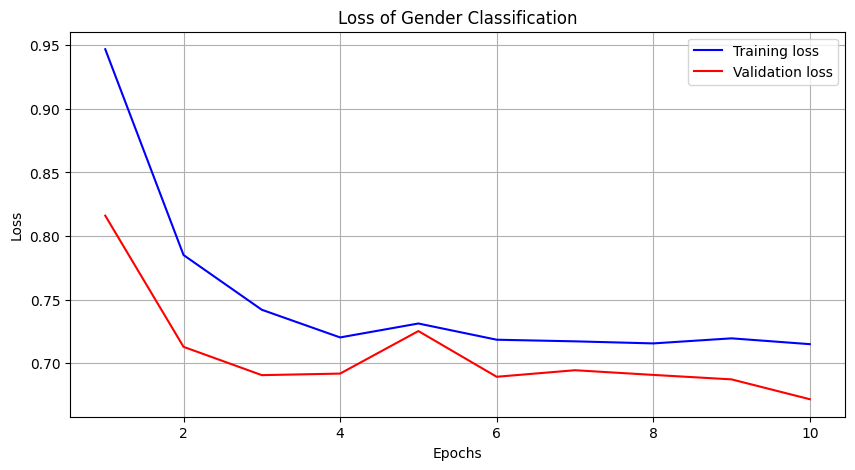

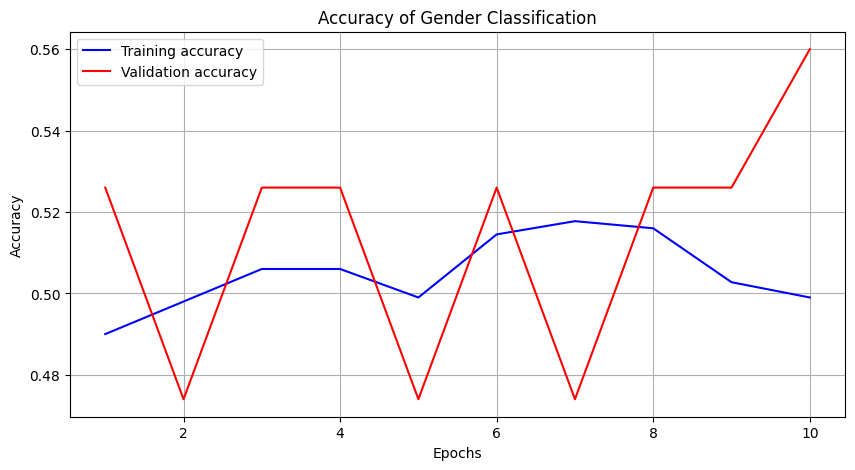

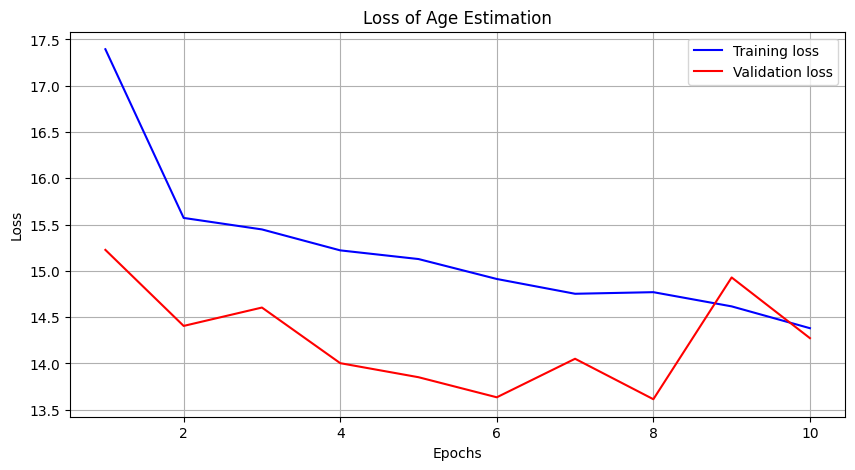

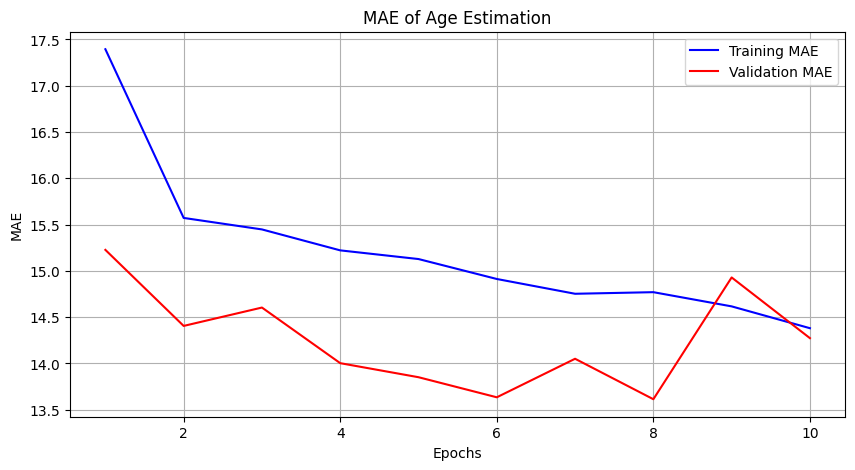

In [10]:
import matplotlib.pyplot as plt

train_loss_gender = history.history['gender_output_loss']
val_loss_gender = history.history['val_gender_output_loss']
train_acc_gender = history.history['gender_output_accuracy']
val_acc_gender = history.history['val_gender_output_accuracy']

train_loss_age = history.history['age_output_loss']
val_loss_age = history.history['val_age_output_loss']
train_mae_age = history.history['age_output_mae']
val_mae_age = history.history['val_age_output_mae']

epochs = range(1, len(train_loss_gender) + 1)

# Plot loss of gender classification over training and validation set
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_gender, 'b', label='Training loss')
plt.plot(epochs, val_loss_gender, 'r', label='Validation loss')
plt.title('Loss of Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot accuracy of gender classification over training and validation set
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_gender, 'b', label='Training accuracy')
plt.plot(epochs, val_acc_gender, 'r', label='Validation accuracy')
plt.title('Accuracy of Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss of age estimation over training and validation set
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_age, 'b', label='Training loss')
plt.plot(epochs, val_loss_age, 'r', label='Validation loss')
plt.title('Loss of Age Estimation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot MAE of age estimation over training and validation set
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_mae_age, 'b', label='Training MAE')
plt.plot(epochs, val_mae_age, 'r', label='Validation MAE')
plt.title('MAE of Age Estimation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()


## STEP2B: Build a CNN network based on a pre-trained model
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**.

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 4, 4, 512)            1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_average_pooling2d (  (None, 512)                  0         ['vgg16[0][0]']               
 GlobalAveragePooling2D)                                                                          
                           

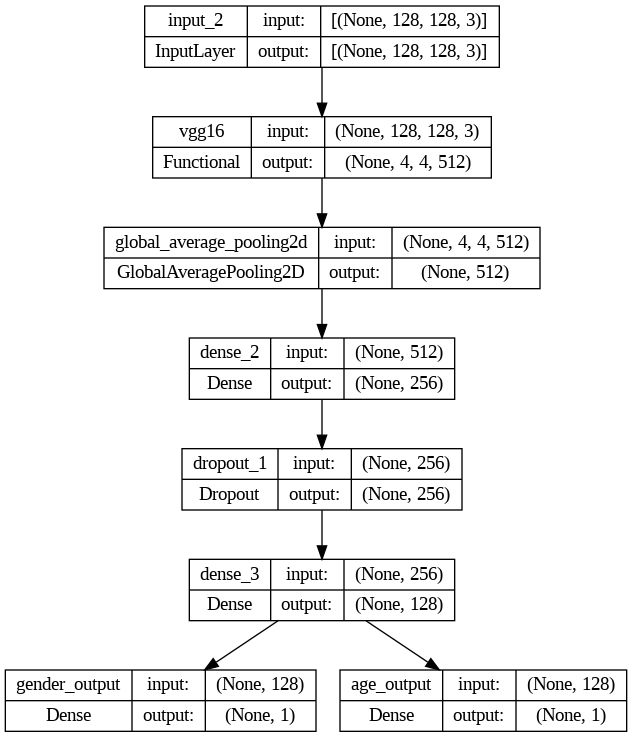

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16

# Define input shape
input_shape = (128, 128, 3)

# Define CNN model
inputs = layers.Input(shape=input_shape)

# Load the pre-trained VGG16 model without the classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the weights of the pre-trained layers
base_model.trainable = False

# Add custom classification layers
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)  # Adjust the number of units as needed


# Gender prediction output
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)

# Age prediction output
age_output = layers.Dense(1, name='age_output')(x)

modelB = Model(inputs=inputs, outputs=[gender_output, age_output])

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.h5` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [13]:
from tensorflow.keras.optimizers import Adam

# Compile the model
modelB.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_absolute_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

# Train the model
history = modelB.fit(train_ds,
                     epochs=10,  # Adjust the number of epochs as needed
                     validation_data=val_ds)

try:
  data_dir.parents[0].mkdir('models')
except FileExistsError:
  pass
except Exception as e:
  pass

modelB.save("models/"+"age_gender_B.h5")

Epoch 1/10
32/32 [==============================] - 42s 1s/step - loss: 20.9180 - gender_output_loss: 0.8062 - age_output_loss: 20.1118 - gender_output_accuracy: 0.5140 - age_output_mae: 20.1118 - val_loss: 15.5931 - val_gender_output_loss: 0.6592 - val_age_output_loss: 14.9340 - val_gender_output_accuracy: 0.6220 - val_age_output_mae: 14.9340
Epoch 2/10
32/32 [==============================] - 28s 788ms/step - loss: 15.5532 - gender_output_loss: 0.7296 - age_output_loss: 14.8237 - gender_output_accuracy: 0.5523 - age_output_mae: 14.8237 - val_loss: 13.7767 - val_gender_output_loss: 0.6292 - val_age_output_loss: 13.1476 - val_gender_output_accuracy: 0.6860 - val_age_output_mae: 13.1476
Epoch 3/10
32/32 [==============================] - 26s 734ms/step - loss: 14.4393 - gender_output_loss: 0.6778 - age_output_loss: 13.7615 - gender_output_accuracy: 0.5995 - age_output_mae: 13.7615 - val_loss: 12.5255 - val_gender_output_loss: 0.6136 - val_age_output_loss: 11.9119 - val_gender_output_acc

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

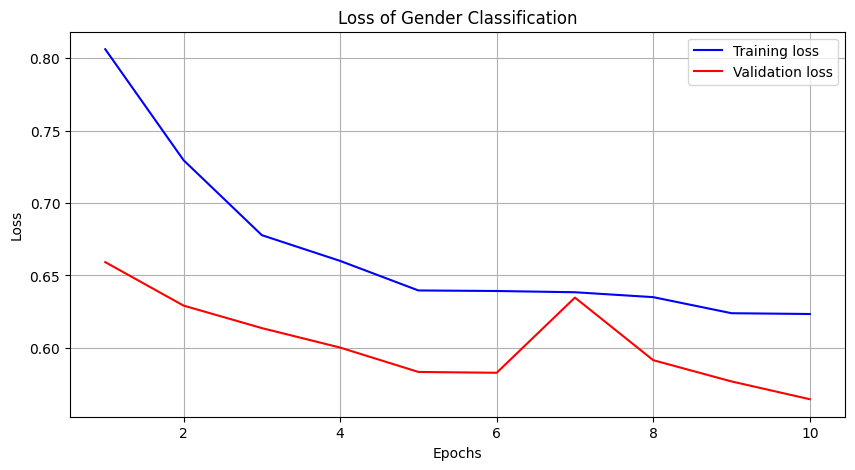

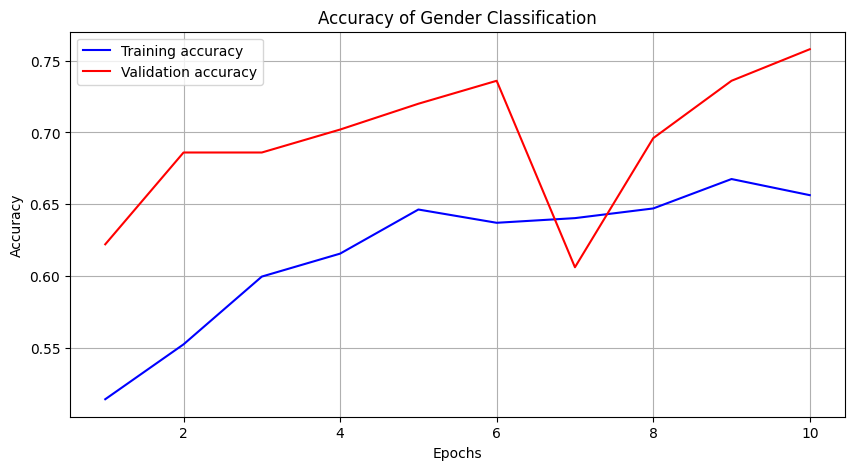

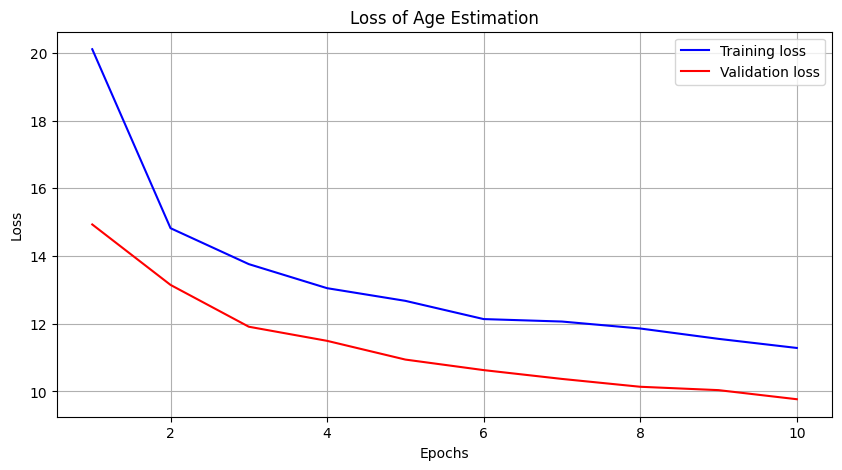

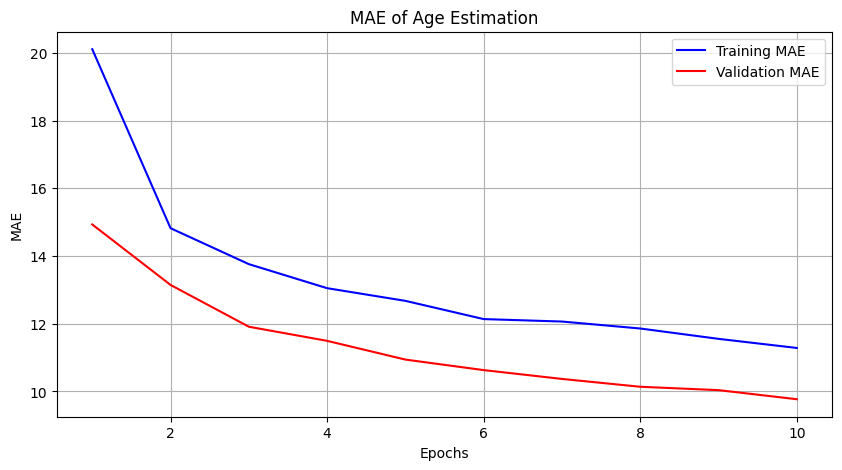

In [14]:
import matplotlib.pyplot as plt

train_loss_gender = history.history['gender_output_loss']
val_loss_gender = history.history['val_gender_output_loss']
train_acc_gender = history.history['gender_output_accuracy']
val_acc_gender = history.history['val_gender_output_accuracy']

train_loss_age = history.history['age_output_loss']
val_loss_age = history.history['val_age_output_loss']
train_mae_age = history.history['age_output_mae']
val_mae_age = history.history['val_age_output_mae']

epochs = range(1, len(train_loss_gender) + 1)

# Plot loss of gender classification over training and validation set
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_gender, 'b', label='Training loss')
plt.plot(epochs, val_loss_gender, 'r', label='Validation loss')
plt.title('Loss of Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot accuracy of gender classification over training and validation set
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_gender, 'b', label='Training accuracy')
plt.plot(epochs, val_acc_gender, 'r', label='Validation accuracy')
plt.title('Accuracy of Gender Classification')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss of age estimation over training and validation set
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_age, 'b', label='Training loss')
plt.plot(epochs, val_loss_age, 'r', label='Validation loss')
plt.title('Loss of Age Estimation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot MAE of age estimation over training and validation set
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_mae_age, 'b', label='Training MAE')
plt.plot(epochs, val_mae_age, 'r', label='Validation MAE')
plt.title('MAE of Age Estimation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#